In [1]:
# fix for HF hub download
# see PR https://github.com/albumentations-team/albumentations/pull/2171
!pip install -U git+https://github.com/qubvel/albumentations@patch-2

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/qubvel/albumentations (to revision patch-2) to /tmp/pip-req-build-y44q11pz
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/albumentations /tmp/pip-req-build-y44q11pz
  Running command git checkout -b patch-2 --track origin/patch-2
  Switched to a new branch 'patch-2'
  Branch 'patch-2' set up to track remote branch 'patch-2' from 'origin'.
  Resolved https://github.com/qubvel/albumentations to commit 6e40b35b92f6be8d9e5ccda5312fa9dcb0383a8c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install certifi
import certifi
import os
os.environ["SSL_CERT_FILE"] = certifi.where()

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install segmentation_models_pytorch

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import requests
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp

from PIL import Image

/home/leeely/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/leeely/.local/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have unknown). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
import os

# Read Hugging Face token
with open('../resources/secrets_and_tokens/huggingface.token', 'r') as f:
    huggingface_token = f.readlines()[0]

# Set the token as an environment variable
os.environ["HF_TOKEN"] = huggingface_token

# You can verify that the token is set correctly
#print(os.environ.get("HF_TOKEN"))

# Restart the runtime.  This is essential for the change to take effect.
# In Colab, go to Runtime -> Restart runtime.
# You can also use a shell command to restart in some environments,
# but that's not reliable in all notebook environments.
# The manual restart is the most robust approach.


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#check for CUDA-enabled GPU
# More checkpoints can be found here:
# https://huggingface.co/collections/smp-hub/segformer-6749eb4923dea2c355f29a1f
checkpoint = "smp-hub/segformer-b2-1024x1024-city-160k" # hold identifier of pre-trained seg model hosted on Hugging Face

# Load pretrained model and preprocessing function
model = smp.from_pretrained(checkpoint).eval().to(device) #eval mode disables dropout, batch norm updates, etc
# dropout - disables some neurons to prevent overfitting
# batch - use fixed mean/variance instead of constantly updating them as in training

preprocessing = A.Compose.from_pretrained(checkpoint)
#loads corresponding image preprocessing pipeline from same checkpoint
#ensures that the preprocessing pipeline used during training is the same as the one used during inference

# Load image
url = "https://huggingface.co/datasets/hf-internal-testing/fixtures_ade20k/resolve/main/ADE_val_00000001.jpg"
image = Image.open(requests.get(url, stream=True).raw)
# fetches and opens image from URL

# Preprocess image
image = np.array(image)  # Converts to NumPy array
normalized_image = preprocessing(image=image)["image"]  # Applies preprocessing pipeline to image
input_tensor = torch.as_tensor(normalized_image, dtype=torch.float32)  # Converts to PyTorch tensor with explicit dtype
input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0)  # Converts dimension order from HWC -> BCHW
input_tensor = input_tensor.to(device)  # Moves input tensor to selected device (CPU or GPU)

# Perform inference
with torch.no_grad(): #disables grad calculations (not needed in inference because they are used to check how much each parameter contributed to error during trainin)
    output_mask = model(input_tensor) #runs model on input tensor

# Postprocess mask
mask = torch.nn.functional.interpolate(
    output_mask, size=image.shape[:2], mode="bilinear", align_corners=False
) #resize output mask to match original image size
mask = mask[0].argmax(0)  # Remains as a PyTorch tensor on the GPU
# #choose class with highest probability for each pixel
#then moves resulting tensor to CPU and converts to np array for visualization

In [7]:
from tqdm import tqdm
from PIL import Image, UnidentifiedImageError

In [8]:
from PIL import Image, ExifTags
import os
import pandas as pd


def extract_gps_coordinates(image_path):
    """Extract latitude and longitude from an image's EXIF GPS data."""
    try:
        image = Image.open(image_path)
        exif_data = image._getexif()
        if not exif_data:
            return None

        # Convert EXIF tag IDs to human-readable names
        exif = {ExifTags.TAGS.get(tag, tag): value for tag, value in exif_data.items()}

        if "GPSInfo" not in exif:
            return None

        gps_info = exif["GPSInfo"]

        # Extract GPS latitude and longitude
        latitude = gps_info.get(2)  # GPSLatitude
        latitude_ref = gps_info.get(1)  # 'N' or 'S'
        longitude = gps_info.get(4)  # GPSLongitude
        longitude_ref = gps_info.get(3)  # 'E' or 'W'

        if latitude and longitude and latitude_ref and longitude_ref:
            # Convert (degrees, minutes, seconds) to decimal format
            lat = latitude[0] + latitude[1] / 60.0 + latitude[2] / 3600.0
            lon = longitude[0] + longitude[1] / 60.0 + longitude[2] / 3600.0

            # Adjust for N/S and E/W
            if latitude_ref == 'S':
                lat = -lat
            if longitude_ref == 'W':
                lon = -lon

            return lat, lon

        return None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Path to images in your cloned GitHub repository
github_folder = "../resources/Building images with GPS"

# Array to store filename and GPS coordinates
image_gps_data = []

# Iterate through images and extract GPS coordinates
for filename in os.listdir(github_folder):
    if filename.lower().endswith(('.jpg', '.jpeg')):  # Only check JPG images
        image_path = os.path.join(github_folder, filename)
        gps_coordinates = extract_gps_coordinates(image_path)
        if gps_coordinates:
            image_gps_data.append({"filename": filename, "latitude": gps_coordinates[0], "longitude": gps_coordinates[1]})

# Print results
for entry in image_gps_data:
    print(f"File: {entry['filename']}, Latitude: {entry['latitude']}, Longitude: {entry['longitude']}")

# Optional: Convert to a DataFrame (if needed for analysis)
import pandas as pd
df = pd.DataFrame(image_gps_data)
print(df)

File: {780461B9-3366-430D-BF71-0340723D371F}.jpg, Latitude: 36.21637075, Longitude: 36.15504469444444
File: {E52E9E22-3D04-47B6-A1C7-62C91B1A2F2D}.jpg, Latitude: 36.56528158333333, Longitude: 36.15630683888889
File: {A0678E82-032A-4D3A-B176-A9FA1FE066D9}.jpg, Latitude: 37.76613088888889, Longitude: 38.266975575
File: {FAEB5345-2C23-4AF0-8A3F-3B5D19D14C64}.jpg, Latitude: 37.55962666666667, Longitude: 36.920289999999994
File: {1A8FF8A6-63FE-4F2F-99FF-CD4B1E3DD047}.jpg, Latitude: 36.23682021111111, Longitude: 36.165431
File: {6B3B4F05-418D-4318-80A0-67FEEE51669C}.jpg, Latitude: 36.23060205555556, Longitude: 36.19999630555555
File: {533D50D1-37C8-4C1D-8FBE-6BA7CCA620AF}.jpg, Latitude: 37.57157127222222, Longitude: 36.936607438888885
File: {09F10EDC-083A-4F26-BB6C-A9AE0CCD766B}.jpg, Latitude: 37.57178513888889, Longitude: 36.93474944722222
File: {D301AEB0-492E-41E4-8D0C-009DEF9F0382}.jpg, Latitude: 37.57303544444445, Longitude: 36.93914701111111
File: {F4FC4A8F-455C-4FE4-8EC1-5A90CDA778F0}.

In [9]:
import pandas as pd

# Define the file path for the Excel file
output_file = '../resources/gps_data.xlsx'

# Save the DataFrame to an Excel file
df.to_excel(output_file, index=False)

print(f"DataFrame saved as Excel file at: {output_file}")

DataFrame saved as Excel file at: ../resources/gps_data.xlsx


In [10]:
import os
import subprocess

# Define the repository path
repo_path = "../resources"

# Change to the repository directory
#os.chdir(repo_path)

# Stage the updated Excel file
#subprocess.run(['git', 'add', 'gps_data.xlsx'], check=True)

# Commit the changes
#subprocess.run(['git', 'commit', '-m', 'Update GPS data Excel file'], check=True)

# Push the changes to the remote repository
#subprocess.run(['git', 'push'], check=True)

#print("Changes have been pushed to the remote GitHub repository.")

Load pretrained model and train on new photos with new clases:
Modifying the Model Architecture:

Load the Pretrained Model:

Start with the SegFormer model pretrained on Cityscapes (which outputs 19 classes).

Created a New Segmentation Head:

To predict 9 classes (all 5 triage categories plus people, background, and machinery), replace the final layer (the segmentation head) with a new convolutional layer that outputs 9 channels.

Copied Pretrained Weights:

For the first 19 channels (corresponding to the Cityscapes classes), copy over the pretrained weights. The new 9 channels (for the new classes) are initialized randomly. This helps preserve the learned features for the original classes while allowing the network to learn the new classes.

In [11]:
# Load the pretrained model (Cityscapes – 19 classes)
checkpoint = "smp-hub/segformer-b2-1024x1024-city-160k"
model = smp.from_pretrained(checkpoint).to(device)

# Define number of classes:
total_classes = 9

# Replace the segmentation head with a new one that outputs 9 channels.
# (Here we assume the segmentation head is a simple Conv2d layer.)
old_head = model.segmentation_head  # typically a SegmentationHead layer
# Get in_channels from the first layer within the SegmentationHead
in_channels = old_head[0].in_channels  # Accessing the in_channels of the Conv2d layer

# Create new head
new_head = torch.nn.Conv2d(in_channels, total_classes, kernel_size=1)

# Optionally, copy the pretrained weights for the first 19 classes
# with torch.no_grad():
    # new_head.weight[:num_cityscapes_classes] = old_head[0].weight
    # new_head.bias[:num_cityscapes_classes] = old_head[0].bias

# The above lines refer to the pretrained weights that take the info from all of
# the previous layers and give the labels names as the original 19 classes.  Therefore, irrelevant

# Replace the head in the model
model.segmentation_head = new_head.to(device)

Preparing the Combined Dataset

Created a Custom Dataset Class:

Define a PyTorch Dataset class (BuildingDataset) that reads images and their corresponding mask files from designated folders.

Preprocessing and Transformations:

Apply the same preprocessing pipeline (using Albumentations) as used during training of the pretrained model. This ensures that the input images are normalized and resized in a consistent way.

Pairing Images with Masks:

The dataset class includes logic to match each mask with its corresponding image using filename patterns.

In [12]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import os
import numpy as np
from PIL import Image
import albumentations as A
import torch
from torch.utils.data import Dataset

# -------------------------
# 1. Define the Dataset with Extra Augmentation for New Data
# -------------------------
class BuildingDataset(Dataset):
    def __init__(self, image_folder, mask_folder, preprocessing, base_transforms=None, augment=False, image_size=(1024, 1024)):
        """
        image_folder: Path to building images.
        mask_folder: Path to corresponding mask images.
        preprocessing: Preprocessing pipeline from the pretrained checkpoint.
        base_transforms: Any basic transforms (applied to all data).
        augment: If True, extra augmentation will be applied.
        """
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.preprocessing = preprocessing
        self.base_transforms = base_transforms
        self.augment = augment
        self.pairs = self._collect_pairs()
        self.image_size = image_size # Store image_size

        # Define extra augmentation pipeline if augment flag is True
        if self.augment:
            self.augmentation_pipeline = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
                A.ColorJitter(p=0.5),
                # Add more augmentations as needed
            ])
        else:
            self.augmentation_pipeline = None

    def _collect_pairs(self):
        pairs = []
        mask_files = [f for f in os.listdir(self.mask_folder) if f.startswith("Label_") and f.endswith(".png")]
        building_files = os.listdir(self.image_folder)

        def find_building_image(base_img_name, building_files):
            for file in building_files:
                if file.startswith(base_img_name):
                    return file
            return None

        for mask_file in mask_files:
            parts = mask_file.split('_')
            if len(parts) < 3:
                continue
            image_part = "_".join(parts[2:])
            base_img_name = os.path.splitext(image_part)[0]
            building_img_file = find_building_image(base_img_name, building_files)
            if building_img_file:
                original_path = os.path.join(self.image_folder, building_img_file)
                mask_path = os.path.join(self.mask_folder, mask_file)
                pairs.append((original_path, mask_path))
        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        image_path, mask_path = self.pairs[idx]
        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))

        # Resize the image and mask to a consistent size
        resize_transform = A.Resize(height=self.image_size[0], width=self.image_size[1]) # Resize using Albumentations
        resized = resize_transform(image=image, mask=mask)
        image, mask = resized["image"], resized["mask"]

        # Apply base transforms if provided
        if self.base_transforms:
            augmented = self.base_transforms(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        # Apply extra augmentation only for the new dataset if enabled
        if self.augment and self.augmentation_pipeline:
            augmented = self.augmentation_pipeline(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        # Preprocess image (e.g., normalization) using the pretrained pipeline
        preprocessed = self.preprocessing(image=image)
        image = preprocessed["image"]
        image = torch.as_tensor(image).permute(2, 0, 1).float()
        mask = torch.as_tensor(mask).long()

        return image, mask

# Example usage for the new dataset with extr augmentation:
image_folder = "../resources/Building images with GPS"
mask_folder = "../resources/Mask_final_relabelled"
# 'preprocessing' should be defined as per your pretrained model's requirements
building_dataset = BuildingDataset(image_folder, mask_folder, preprocessing, base_transforms=None, augment=True)


# -------------------------
# 2. Freeze the Encoder Layers of the Model
# -------------------------
# Assume your model is loaded as shown:
# model = smp.from_pretrained(checkpoint).eval().to(device)

# Freeze all parameters in the encoder to prevent them from updating during training.
for param in model.encoder.parameters():
    param.requires_grad = False

print("Encoder layers frozen. Only the head and later layers will be trained.")

Encoder layers frozen. Only the head and later layers will be trained.


In [13]:
import os

# Get a list of all building image filenames
all_building_files = os.listdir(image_folder)

# Get a list of mask filenames (they start with "Label_")
mask_files = [f for f in os.listdir(mask_folder) if f.startswith("Label_") and f.endswith(".png")]

def extract_base_name(mask_filename):
    # Assumes mask filename like "Label_2_BE123.png", returns "BE123"
    parts = mask_filename.split('_')
    if len(parts) < 3:
        return None
    image_part = "_".join(parts[2:])
    base_img_name = os.path.splitext(image_part)[0]
    return base_img_name

# Determine the set of labeled building image base names
labeled_bases = set()
for mask_file in mask_files:
    base = extract_base_name(mask_file)
    if base:
        labeled_bases.add(base)

# Identify unlabeled images by checking if the filename's base is not in labeled_bases
unlabeled_files = []
for file in all_building_files:
    base_name = os.path.splitext(file)[0]
    if base_name not in labeled_bases:
        unlabeled_files.append(os.path.join(image_folder, file))

print(f"Found {len(unlabeled_files)} unlabeled building images.")

# Create val_pairs for labeled images: a pair of (image_path, mask_path)
val_pairs = []
for mask_file in mask_files:
    base = extract_base_name(mask_file)
    if base:
        # Find the corresponding image whose filename starts with the base name
        for file in all_building_files:
            if file.startswith(base):
                image_path = os.path.join(image_folder, file)
                mask_path = os.path.join(mask_folder, mask_file)
                val_pairs.append((image_path, mask_path))
                break

print(f"Found {len(val_pairs)} labeled (validation) pairs.")


Found 22 unlabeled building images.
Found 326 labeled (validation) pairs.


Setting Up the Training Pipeline

DataLoader:

Create a DataLoader to iterate over our dataset in batches, shuffling the data for training.

Loss Function:

Use the CrossEntropyLoss, which is suitable for multi-class segmentation problems (each pixel belongs to one class).

Optimizer:

Use the Adam optimizer with a specified learning rate to update the model's weights during training.

Training Loop:

The loop iterates over several epochs, processes batches of images and masks, performs forward passes through the model, computes the loss, and backpropagates the error to update weights.

In [14]:
import os
import numpy as np
from PIL import Image

# Get a list of all mask files (assuming PNG format)
mask_files = [os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.endswith('.png')]

# Define number of classes (adjust if necessary; here we assume classes 0 through 8)
num_classes = 9

# Initialize an array to accumulate pixel counts for each class
class_pixel_counts = np.zeros(num_classes, dtype=np.int64)
total_pixels = 0

# Loop through all mask images
for mask_file in mask_files:
    try:
        mask_img = np.array(Image.open(mask_file))
    except Exception as e:
        print(f"Error reading {mask_file}: {e}")
        continue

    # Flatten the mask to 1D array and count pixels per class
    counts = np.bincount(mask_img.flatten(), minlength=num_classes)
    class_pixel_counts += counts
    total_pixels += mask_img.size

# Compute the percentage of pixels for each class
percentages = (class_pixel_counts / total_pixels) * 100

print("Pixel percentages per class:")
for i, perc in enumerate(percentages):
    print(f"Class {i}: {perc:.2f}%")

Pixel percentages per class:
Class 0: 36.59%
Class 1: 2.10%
Class 2: 3.80%
Class 3: 3.32%
Class 4: 2.71%
Class 5: 9.63%
Class 6: 14.35%
Class 7: 6.33%
Class 8: 21.18%


class_mentioned

Epoch 1: Train Loss: 1.9982, Val Loss: 1.6983, LR: 0.001000
Epoch 2: Train Loss: 1.8097, Val Loss: 1.6154, LR: 0.001000
Epoch 3: Train Loss: 1.7337, Val Loss: 1.5924, LR: 0.001000
Epoch 4: Train Loss: 1.7047, Val Loss: 1.5897, LR: 0.001000
Loss diff 0.00270 below epsilon. Patience: 1/3
Epoch 5: Train Loss: 1.6934, Val Loss: 1.5533, LR: 0.001000
Epoch 6: Train Loss: 1.6230, Val Loss: 1.5957, LR: 0.001000
Epoch 7: Train Loss: 1.6421, Val Loss: 1.5469, LR: 0.001000
Epoch 8: Train Loss: 1.6262, Val Loss: 1.6092, LR: 0.001000
Epoch 9: Train Loss: 1.6555, Val Loss: 1.5785, LR: 0.001000
Epoch 10: Train Loss: 1.6039, Val Loss: 1.5696, LR: 0.000500
Epoch 11: Train Loss: 1.5603, Val Loss: 1.5308, LR: 0.000500
Epoch 12: Train Loss: 1.5603, Val Loss: 1.5007, LR: 0.000500
Epoch 13: Train Loss: 1.5909, Val Loss: 1.5179, LR: 0.000500
Epoch 14: Train Loss: 1.5680, Val Loss: 1.4935, LR: 0.000500
Epoch 15: Train Loss: 1.5322, Val Loss: 1.5087, LR: 0.000500
Epoch 16: Train Loss: 1.5596, Val Loss: 1.5039,

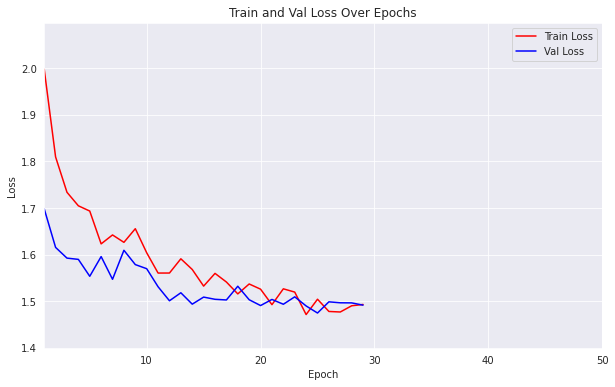

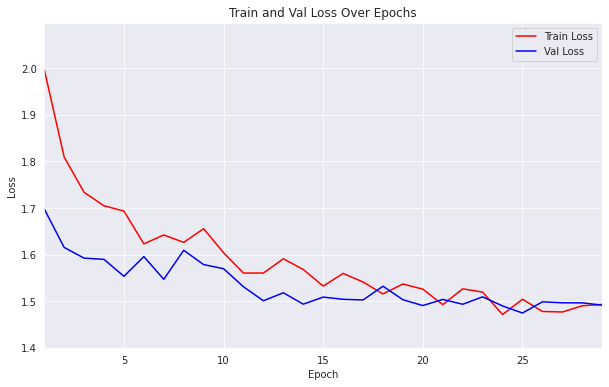

In [15]:
import torch
from torch.utils.data import random_split, DataLoader
import torch.optim as optim

# Assuming building_dataset is already defined from your earlier code.
dataset_size = len(building_dataset)
val_size = int(0.2 * dataset_size)       # e.g., 20% for validation
train_size = dataset_size - val_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(building_dataset, [train_size, val_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

# Suppose you computed class_pixel_counts via bincount
total_pixels = sum(class_pixel_counts)
class_weights = [total_pixels / count for count in class_pixel_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define your optimizer (Adam) with an initial learning rate.
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Define a scheduler that reduces the LR if the validation loss doesn't improve.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

epsilon = 0.005  # Minimum relative improvement (0.5% improvement)
patience_threshold = 3  # Stop if improvement is below epsilon for 3 consecutive epochs
patience_counter = 0
previous_val_loss = None
train_losses = []
val_losses = []

num_epochs = 50  # Set maximum epochs

for epoch in range(num_epochs):
    model.train()  # Training mode
    train_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        outputs = torch.nn.functional.interpolate(
            outputs, size=masks.shape[1:], mode="bilinear", align_corners=False
        )

        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()  # Evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            outputs = torch.nn.functional.interpolate(
                outputs, size=masks.shape[1:], mode="bilinear", align_corners=False
            )
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Step the scheduler with the validation loss
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {current_lr:.6f}")

    # Early stopping: check absolute difference in validation loss
    if previous_val_loss is not None:
        loss_diff = abs(avg_val_loss - previous_val_loss)
        if loss_diff < epsilon:
            patience_counter += 1
            print(f"Loss diff {loss_diff:.5f} below epsilon. Patience: {patience_counter}/{patience_threshold}")
        else:
            patience_counter = 0
    previous_val_loss = avg_val_loss

    if patience_counter >= patience_threshold:
        print("Early stopping triggered!")
        break
plt.figure(figsize=(10, 6))
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'r-', label='Train Loss')
plt.plot(epochs, val_losses, 'b-', label='Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Val Loss Over Epochs')
plt.legend()

# Automatically adjust the x and y limits based on data
plt.xlim(1, num_epochs)
plt.ylim(min(min(train_losses), min(val_losses)) * 0.95, max(max(train_losses), max(val_losses)) * 1.05)


import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'r-', label='Train Loss')
plt.plot(epochs, val_losses, 'b-', label='Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Val Loss Over Epochs')
plt.legend()

# Automatically adjust the x and y limits based on data
plt.xlim(1, len(train_losses))
plt.ylim(min(min(train_losses), min(val_losses)) * 0.95, max(max(train_losses), max(val_losses)) * 1.05)

# Display the plot
plt.show()

Updated loop with fixed scheduler, early stopping, and loss tracking:

In [16]:
import os
import torch

# Define the path to save the weights
save_path = "../resources/class_weights.pt"

# Save the class weights
torch.save(class_weights, save_path)

print(f"Class weights saved to: {save_path}")

Class weights saved to: ../resources/class_weights.pt


In [17]:
torch.save(model.state_dict(), "../resources/class_weights.pt")

model.load_state_dict(torch.load("../resources/class_weights.pt"))


<All keys matched successfully>

Making predictions on unseen photos:
Performing Inference

Image Loading and Preprocessing:

Load a new image and apply the same preprocessing (normalization, resizing) as during training.

Forward Pass:

The image is passed through the model (set in evaluation mode), and the output is a tensor with 9 channels.

Postprocessing:

Use argmax to choose the class with the highest probability for each pixel, then resize the mask to the original image dimensions.

In [18]:
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# Define your class mapping (adjust indices and names as needed)
class_names = {
    0: "Background",
    1: "Machinery",
    2: "Personnel",
    3: "Damage: Level A",
    4: "Damage: Level B",
    5: "Damage: Level C",
    6: "Damage: Level D",
    7: "Damage: Level E",
    8: "Damage: Level F"

}

# Define your colors for each class (ensure you have one per class, here we have 26 colors)
colors = [
    (0, 0, 0),                # Label 0: background (set as black, for example)
    (0, 0.4470, 0.7410),       # Label 1 ('Machinery')
    (0.8500, 0.3250, 0.0980),  # Label 2 ('Personnel')
    (0.9290, 0.6940, 0.1250),  # Label 3 ('A')
    (0.4940, 0.1840, 0.5560),  # Label 4 ('B')
    (0.4660, 0.6740, 0.1880),  # Label 5 ('C')
    (0.3010, 0.7450, 0.9330),  # Label 6 ('D')
    (0.6350, 0.0780, 0.1840),  # Label 7 ('E')
    (1, 0, 0)                 # Label 8 ('F')
]

# Create a ListedColormap from these colors
custom_cmap = ListedColormap(colors)

# Create legend patches for each class
patches = [mpatches.Patch(color=custom_cmap(i), label=class_names[i])
           for i in sorted(class_names.keys())]

In [19]:
def perform_segmentation(image_path, model, preprocessing):
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error opening image {image_path}: {e}")
        return None, None

    image_np = np.array(image)
    # Apply the same preprocessing pipeline as during training
    normalized = preprocessing(image=image_np)["image"]
    input_tensor = torch.as_tensor(normalized).permute(2, 0, 1).unsqueeze(0).float().to(device)

    model.eval()
    with torch.no_grad():
        output_mask = model(input_tensor)

    # Resize output to match original image size if needed
    output_mask = torch.nn.functional.interpolate(
        output_mask, size=image_np.shape[:2], mode="bilinear", align_corners=False
    )
    mask = output_mask[0].argmax(0).cpu().numpy()
    # Convert the mask to uint8 before color conversion
    mask = mask.astype(np.uint8)

    return image_np, mask

# Example usage:
test_image_path = unlabeled_files[1]
image_np, mask = perform_segmentation(test_image_path, model, preprocessing)

output_dir = "inference_outputs"
os.makedirs(output_dir, exist_ok=True)

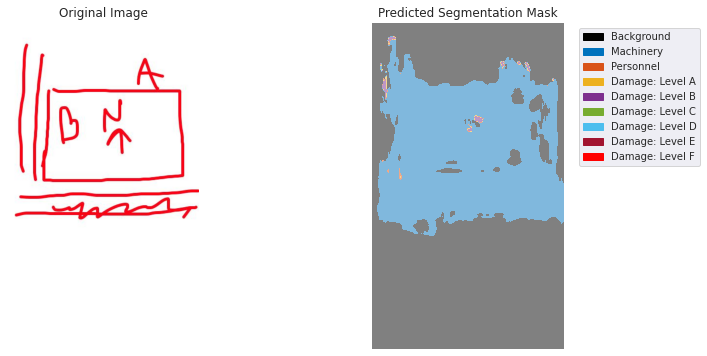

Saved segmentation for {957955C7-AC79-42BF-8FE9-0E8B532D13C1}.jpg to inference_outputs/seg_{957955C7-AC79-42BF-8FE9-0E8B532D13C1}.jpg


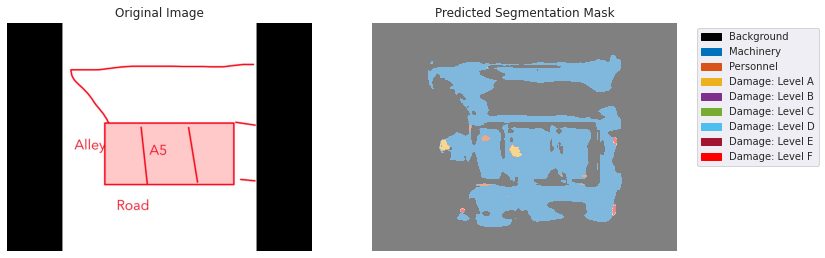

Saved segmentation for {C6BEE5A4-9718-46E5-8BEC-42FD24DA2406}.jpg to inference_outputs/seg_{C6BEE5A4-9718-46E5-8BEC-42FD24DA2406}.jpg


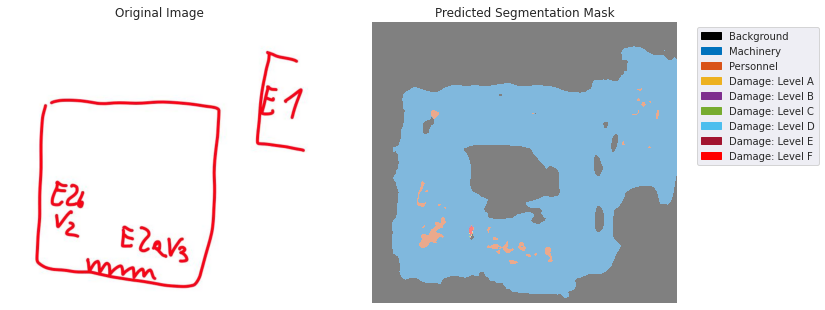

Saved segmentation for {C226CB86-BD2F-4834-9056-E34651C57D76}.jpg to inference_outputs/seg_{C226CB86-BD2F-4834-9056-E34651C57D76}.jpg


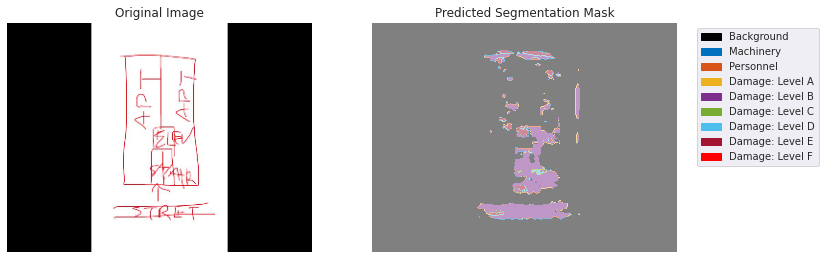

Saved segmentation for {9AB8059A-C322-414D-8B9F-1DD889B61969}.jpg to inference_outputs/seg_{9AB8059A-C322-414D-8B9F-1DD889B61969}.jpg


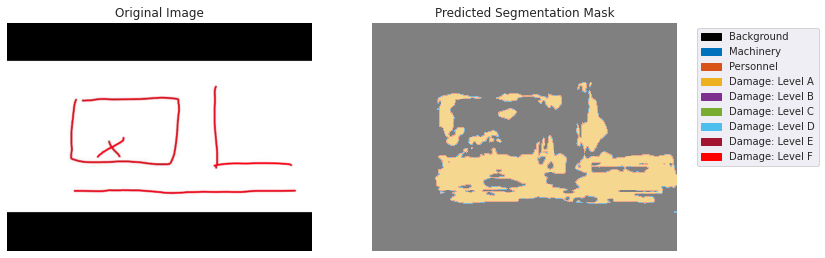

Saved segmentation for {730B3EEB-D963-43DA-BB71-5B6B7AF31A86}.jpg to inference_outputs/seg_{730B3EEB-D963-43DA-BB71-5B6B7AF31A86}.jpg


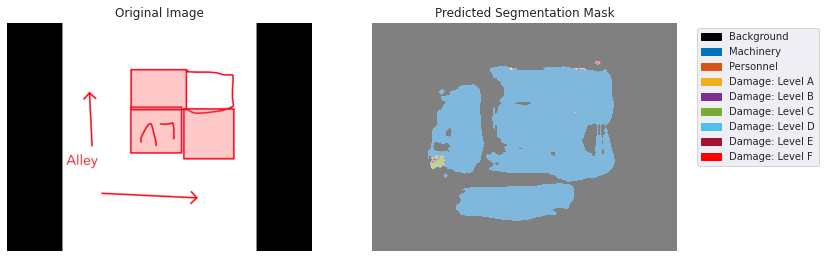

Saved segmentation for {595EB95D-8135-4B5E-A6B9-359AA624C450}.jpg to inference_outputs/seg_{595EB95D-8135-4B5E-A6B9-359AA624C450}.jpg


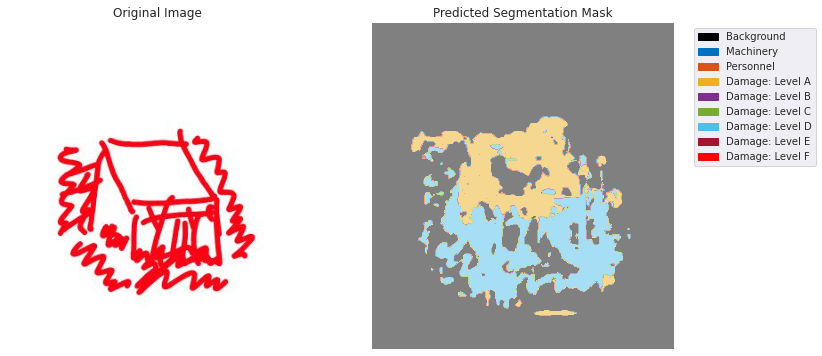

Saved segmentation for {4FB04A3B-5B94-45C9-9F88-F5C7BD978EC0}.jpg to inference_outputs/seg_{4FB04A3B-5B94-45C9-9F88-F5C7BD978EC0}.jpg


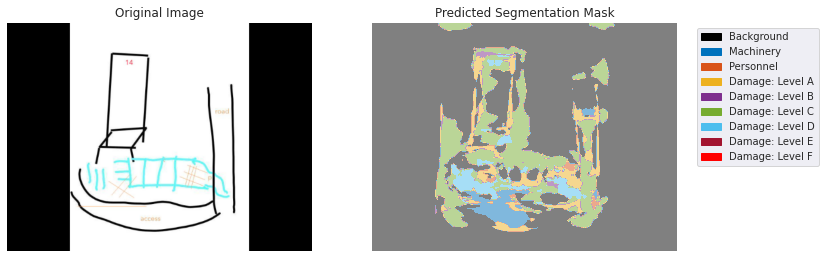

Saved segmentation for {6FD84076-EC47-41D2-813C-30BF1FBAAB63}.jpg to inference_outputs/seg_{6FD84076-EC47-41D2-813C-30BF1FBAAB63}.jpg


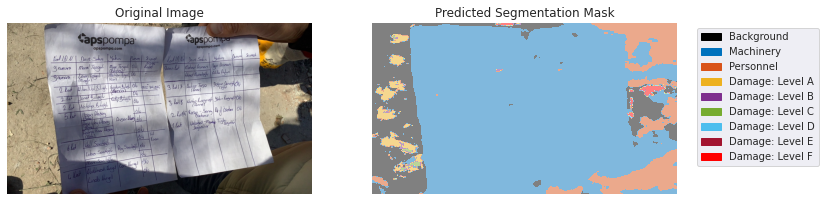

Saved segmentation for {068A4180-C955-40E0-B385-BFC75D3C9354}.jpg to inference_outputs/seg_{068A4180-C955-40E0-B385-BFC75D3C9354}.jpg


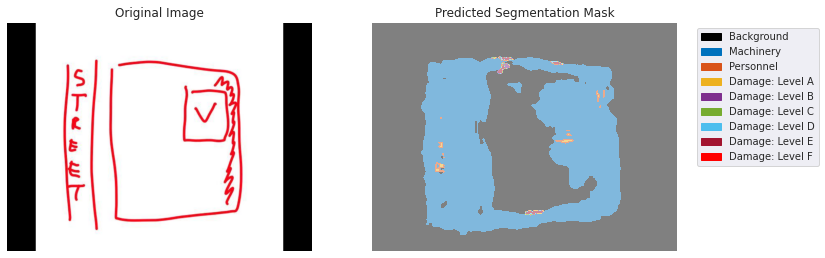

Saved segmentation for {32CBDBEC-142A-48D6-8646-5462725F94C3}.jpg to inference_outputs/seg_{32CBDBEC-142A-48D6-8646-5462725F94C3}.jpg


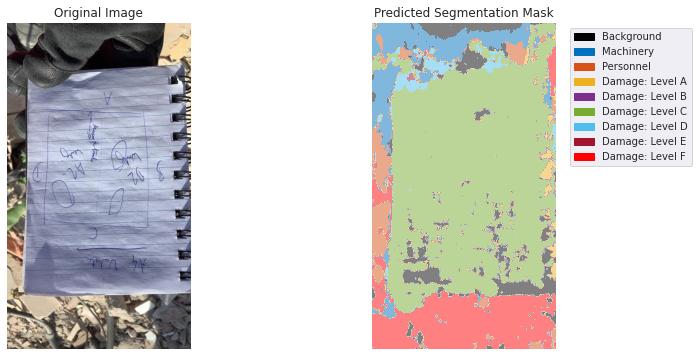

Saved segmentation for {09B0A8BE-FC31-4BCD-9286-E6C3D6D4E400}.jpg to inference_outputs/seg_{09B0A8BE-FC31-4BCD-9286-E6C3D6D4E400}.jpg


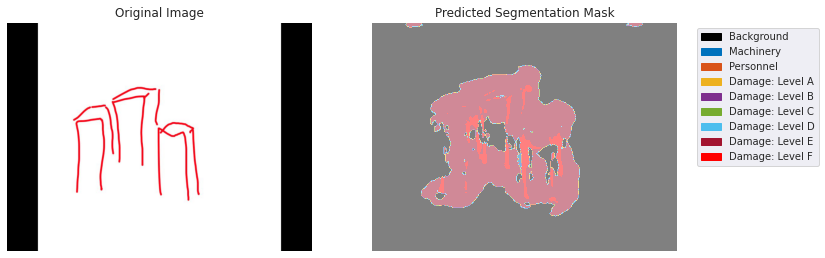

Saved segmentation for {E71A5C4A-AEDB-4A62-9E0D-E425ECCB21C8}.jpg to inference_outputs/seg_{E71A5C4A-AEDB-4A62-9E0D-E425ECCB21C8}.jpg


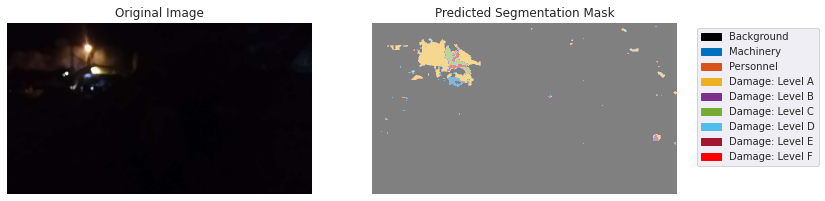

Saved segmentation for {292912A9-674E-4A41-89DD-7F0E0E550A84}.jpg to inference_outputs/seg_{292912A9-674E-4A41-89DD-7F0E0E550A84}.jpg


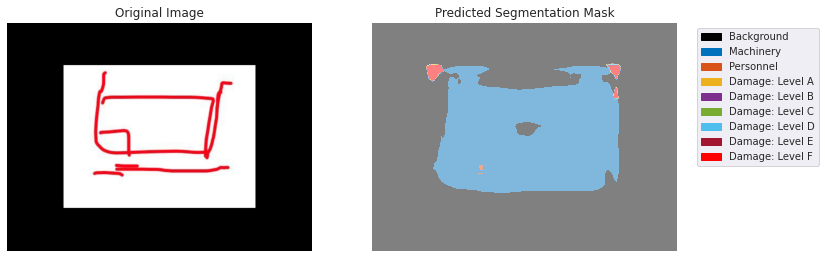

Saved segmentation for {212216A8-1FF2-488A-9FA6-0827660C6CE2}.jpg to inference_outputs/seg_{212216A8-1FF2-488A-9FA6-0827660C6CE2}.jpg


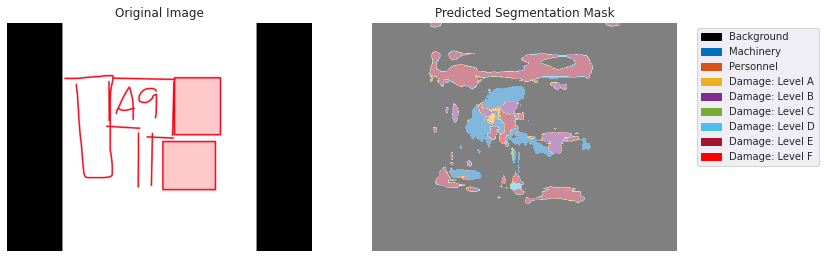

Saved segmentation for {90E81981-40FD-45CC-A45E-8D3AA731ECB9}.jpg to inference_outputs/seg_{90E81981-40FD-45CC-A45E-8D3AA731ECB9}.jpg


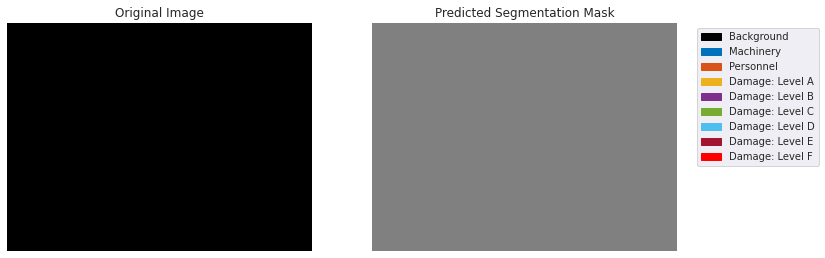

Saved segmentation for {BFB77A46-9F4A-4F0D-B58A-9A2F18BB3B4E}.jpg to inference_outputs/seg_{BFB77A46-9F4A-4F0D-B58A-9A2F18BB3B4E}.jpg


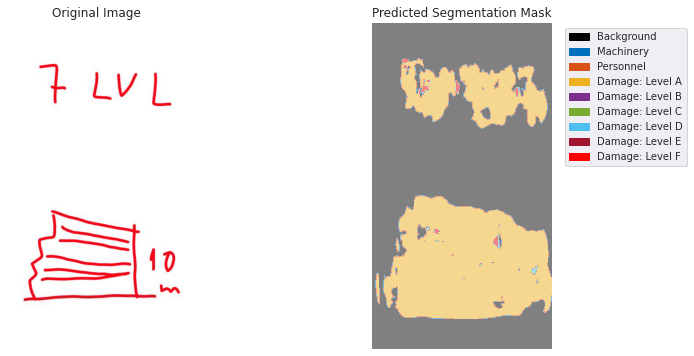

Saved segmentation for {BEE0083B-0D0E-4382-8CCE-C00193BE314D}.jpg to inference_outputs/seg_{BEE0083B-0D0E-4382-8CCE-C00193BE314D}.jpg


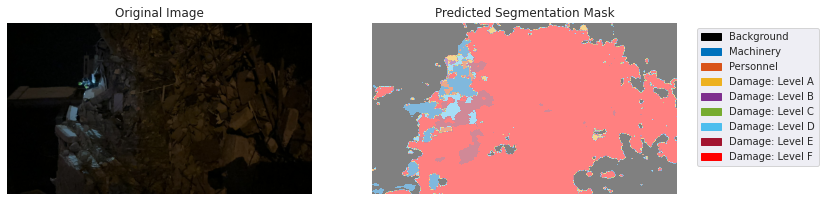

Saved segmentation for {BE32E2E9-8598-457A-AC40-94DE5C1BFC47}.jpg to inference_outputs/seg_{BE32E2E9-8598-457A-AC40-94DE5C1BFC47}.jpg


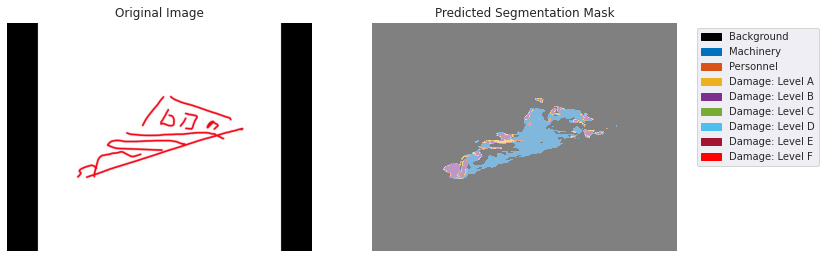

Saved segmentation for {EB439EF3-5195-4E12-9EC7-C04E0EB641A2}.jpg to inference_outputs/seg_{EB439EF3-5195-4E12-9EC7-C04E0EB641A2}.jpg


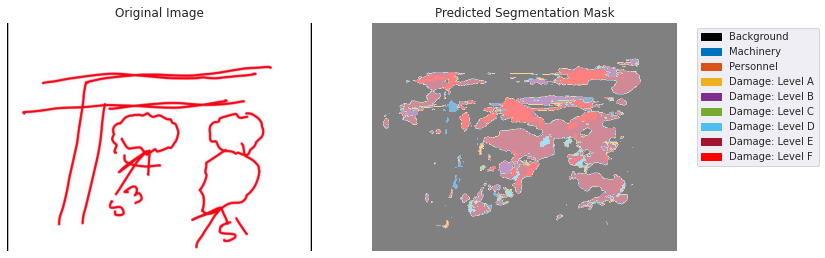

Saved segmentation for {A8D9F24E-31A9-4F3A-8002-5FAEC0A127F6}.jpg to inference_outputs/seg_{A8D9F24E-31A9-4F3A-8002-5FAEC0A127F6}.jpg


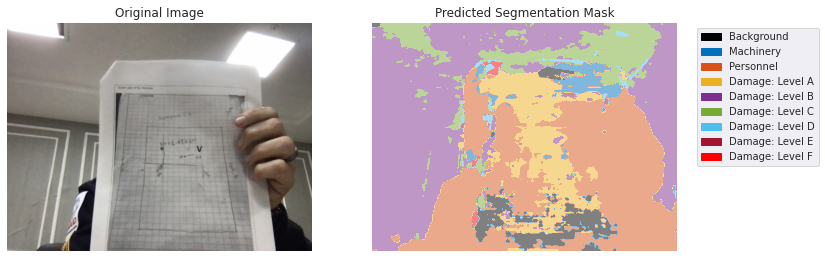

Saved segmentation for {13BE3E10-B381-43CE-8A10-A1D086BE432F}.jpg to inference_outputs/seg_{13BE3E10-B381-43CE-8A10-A1D086BE432F}.jpg


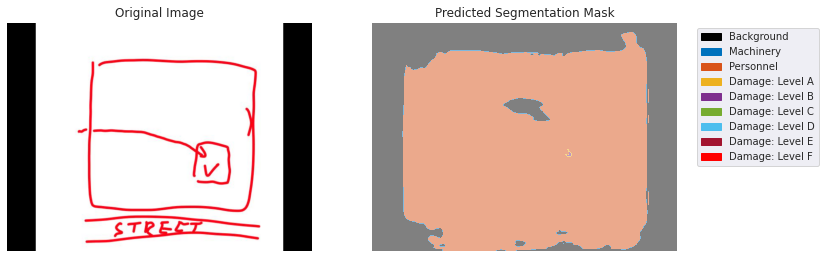

Saved segmentation for {1EE7A75A-531C-44C5-8DAE-5B7AE08CE627}.jpg to inference_outputs/seg_{1EE7A75A-531C-44C5-8DAE-5B7AE08CE627}.jpg


In [20]:
for img_path in unlabeled_files:
    try:
        image_np, mask = perform_segmentation(img_path, model, preprocessing)

        # Check if image_np is valid before proceeding
        if image_np is None or mask is None or image_np.dtype == object:
            print(f"Skipping image {img_path} due to error or invalid data type.")
            continue  # Skip to the next image

    except UnidentifiedImageError:
        print(f"Skipping file {img_path} as it cannot be identified as an image.")
        continue  # Skip to the next image

# Optionally, display the result
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=custom_cmap, alpha=0.5)
    plt.title("Predicted Segmentation Mask")
    plt.axis("off")
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # Save the colored segmentation mask
    basename = os.path.basename(img_path)
    out_path = os.path.join(output_dir, f"seg_{basename}")
    cv2.imwrite(out_path, cv2.cvtColor(mask, cv2.COLOR_RGB2BGR))
    print(f"Saved segmentation for {basename} to {out_path}")

In [21]:
import os

# Base directory for saving images in the GitHub repository
base_dir = "../resources"

# Subdirectory for image comparisons
comparison_dir = os.path.join(base_dir, "Image Comparisons")

# Create the directory if it does not exist
os.makedirs(comparison_dir, exist_ok=True)

In [24]:
# Subdirectory for image comparison
pred_dir = os.path.join(base_dir, "pred_masks_final")

# Create the directory if it does not exist
os.makedirs(pred_dir, exist_ok=True)

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, UnidentifiedImageError

original_dir = "../resources/Building images with GPS"
gt_dir = "../resources/Mask_final_relabelled"
pred_dir = "../resources/pred_masks_final"
# Assume val_pairs is a list of tuples: (img_path, gt_mask_path)
# For example, you might have constructed it similarly to how you collected pairs for training.
# val_pairs = [(img_path1, gt_mask_path1), (img_path2, gt_mask_path2), ...]

# Loop through validation pairs (original image and ground truth mask)
for img_path, gt_mask_path in val_pairs:
    try:
        # Load original image
        image_pil = Image.open(img_path).convert("RGB")
        image_np = np.array(image_pil)

        # Load ground-truth mask
        gt_mask_pil = Image.open(gt_mask_path)
        gt_mask = np.array(gt_mask_pil)

        # Perform segmentation on the image using your model
        _, pred_mask = perform_segmentation(img_path, model, preprocessing)

        # Validate outputs
        if image_np is None or pred_mask is None or image_np.dtype == object:
            print(f"Skipping image {img_path} due to error or invalid data type.")
            continue

    except UnidentifiedImageError:
        print(f"Skipping file {img_path} as it cannot be identified as an image.")
        continue

    # Extract filename without extension
    filename = os.path.splitext(os.path.basename(img_path))[0]

    # Save the original image
    Image.fromarray(image_np).save(os.path.join(original_dir, f"{filename}.png"))

    # Save the ground-truth mask
    Image.fromarray(gt_mask).save(os.path.join(gt_dir, f"{filename}.png"))

    # Save the predicted segmentation mask
    Image.fromarray(pred_mask).save(os.path.join(pred_dir, f"{filename}.png"))

    # Create a side-by-side comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(image_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(image_np)
    axes[1].imshow(gt_mask, cmap=custom_cmap, alpha=0.5)
    axes[1].set_title("Ground Truth Segmentation")
    axes[1].axis("off")

    axes[2].imshow(image_np)
    axes[2].imshow(pred_mask, cmap=custom_cmap, alpha=0.5)
    axes[2].set_title("Predicted Segmentation")
    axes[2].axis("off")

    # Save comparison image
    comparison_path = os.path.join(comparison_dir, f"{filename}.png")
    plt.savefig(comparison_path, bbox_inches="tight", pad_inches=0.1, dpi=300)
    plt.close(fig)

    print(f"Saved comparison for {filename} to {comparison_path}")

Saved comparison for {C165CBE8-C191-4C8A-AD79-ACB5DC61936C} to ../resources/Image Comparisons/{C165CBE8-C191-4C8A-AD79-ACB5DC61936C}.png
Saved comparison for {C4EFA374-6F6C-45D4-B48F-82A60766854C} to ../resources/Image Comparisons/{C4EFA374-6F6C-45D4-B48F-82A60766854C}.png
Saved comparison for {9CB58159-DB90-4641-BAAE-DA7D123CF1CA} to ../resources/Image Comparisons/{9CB58159-DB90-4641-BAAE-DA7D123CF1CA}.png
Saved comparison for {8677E52A-A4A6-47AE-B373-0A891D0BAE64} to ../resources/Image Comparisons/{8677E52A-A4A6-47AE-B373-0A891D0BAE64}.png
Saved comparison for {F8E6D8C1-7DC7-40D2-9BE2-A7D5F653E380} to ../resources/Image Comparisons/{F8E6D8C1-7DC7-40D2-9BE2-A7D5F653E380}.png
Saved comparison for {81011EC3-C0CB-40B2-8ACB-34FACE9B1E9C} to ../resources/Image Comparisons/{81011EC3-C0CB-40B2-8ACB-34FACE9B1E9C}.png
Saved comparison for {B13E60C2-7DF5-47D0-9057-E7AD84699544} to ../resources/Image Comparisons/{B13E60C2-7DF5-47D0-9057-E7AD84699544}.png
Saved comparison for {8ABA5D32-68F5-4B8C-

In [26]:
import numpy as np

def compute_iou(pred_mask, gt_mask, num_classes):
    """
    Compute IoU for each class for a single image.
    Returns a list of IoUs for each class.
    """
    # Ensure pred_mask and gt_mask have the same shape
    if pred_mask.shape != gt_mask.shape:
        pred_mask = pred_mask.transpose()  # Transpose if shapes are reversed

    iou_list = []
    for cls in range(num_classes):
        pred_cls = (pred_mask == cls)
        gt_cls = (gt_mask == cls)
        intersection = np.logical_and(pred_cls, gt_cls).sum()
        union = np.logical_or(pred_cls, gt_cls).sum()
        if union == 0:
            iou = np.nan  # If no ground truth for this class exists, mark as nan.
        else:
            iou = intersection / union
        iou_list.append(iou)
    return iou_list

# Suppose val_pairs is a list of (img_path, gt_mask_path) for validation.
num_classes = 9  # Adjust as necessary.
all_ious = []  # List to store IoU for each image.

for img_path, gt_mask_path in val_pairs:
    # Load ground truth mask
    gt_mask = np.array(Image.open(gt_mask_path))
    # Compute prediction
    _, pred_mask = perform_segmentation(img_path, model, preprocessing)
    # Compute IoU per class for this image.
    ious = compute_iou(pred_mask, gt_mask, num_classes)
    all_ious.append(ious)

# Convert to numpy array for easier averaging (shape: num_images x num_classes)
all_ious = np.array(all_ious)
# Compute mean IoU per class (ignoring nan values) and overall mean IoU
mean_iou_per_class = np.nanmean(all_ious, axis=0)
overall_mean_iou = np.nanmean(mean_iou_per_class)

print("Mean IoU per class:", mean_iou_per_class)
print("Overall Mean IoU:", overall_mean_iou)



Mean IoU per class: [0.53450357 0.11817411 0.22536501 0.13293452 0.0387319  0.11711568
 0.08948204 0.12119303 0.33841176]
Overall Mean IoU: 0.19065684548160508


In [27]:
import os
import numpy as np

# Define your save directory within the local Git repository
repo_dir = "../resources"
save_dir = os.path.join(repo_dir, "IoUs")
os.makedirs(save_dir, exist_ok=True)

# Save the full IoU array as a .npy file
all_ious_path = os.path.join(save_dir, "all_ious.npy")
np.save(all_ious_path, all_ious)

# Save the mean IoU per class as a .npy file
mean_iou_per_class_path = os.path.join(save_dir, "mean_iou_per_class.npy")
np.save(mean_iou_per_class_path, mean_iou_per_class)

# Save the overall mean IoU in a text file
overall_mean_iou_path = os.path.join(save_dir, "overall_mean_iou.txt")
with open(overall_mean_iou_path, "w") as f:
    f.write(f"Overall Mean IoU: {overall_mean_iou}\n")

print(f"Saved IoU arrays to {save_dir}")

Saved IoU arrays to ../resources/IoUs


In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from PIL import Image

# Define your class mapping (adjust names as needed)
class_names = {
    0: "Background",
    1: "Machinery",
    2: "Personnel",
    3: "A",
    4: "B",
    5: "C",
    6: "D",
    7: "E",
    8: "F"
}

num_classes = 9  # Number of classes

# Lists to accumulate flattened ground truth and predictions
all_gt = []
all_pred = []

for img_path, gt_mask_path in val_pairs:
    try:
        # Load ground truth mask
        gt_mask = np.array(Image.open(gt_mask_path))

        # Perform segmentation on the image using your model
        _, pred_mask = perform_segmentation(img_path, model, preprocessing)

        # Validate shapes if necessary and flatten arrays
        all_gt.append(gt_mask.flatten())
        all_pred.append(pred_mask.flatten())

    except Exception as e:
        print(f"Skipping {img_path} due to error: {e}")
        continue

# Concatenate all flattened arrays
all_gt = np.concatenate(all_gt)
all_pred = np.concatenate(all_pred)

# Compute the confusion matrix
cm = confusion_matrix(all_gt, all_pred, labels=list(range(num_classes)))

# Convert the confusion matrix to a DataFrame for better readability
cm_df = pd.DataFrame(cm,
                     index=[class_names[i] for i in range(num_classes)],
                     columns=[class_names[i] for i in range(num_classes)])

print("Confusion Matrix:")
print(cm_df)

Confusion Matrix:
            Background  Machinery  Personnel        A        B         C  \
Background    85706331    7506741    6878704  6168307  3075891   6276433   
Machinery       471999    5636619     366392   242829    42034    117881   
Personnel       816949     547108   11377587   136190    40658    225286   
A               816660     372890     254993  8591856   574833    679131   
B               449411     322876     141194  2379633  3309006   2942746   
C              2559710     714178     411812  3358708  2126086  23431897   
D              3375713    3085507    1416966  4190569  1546329  12479624   
E              1048318    1269519     750212   565581   219968   1427263   
F              7642061    2640451    4559669  2452487   808759   2631961   

                   D         E         F  
Background   4143238   5192655  12464162  
Machinery     179656    344433    469803  
Personnel     171169    388293    557573  
A             334503    243004    613335  
B     

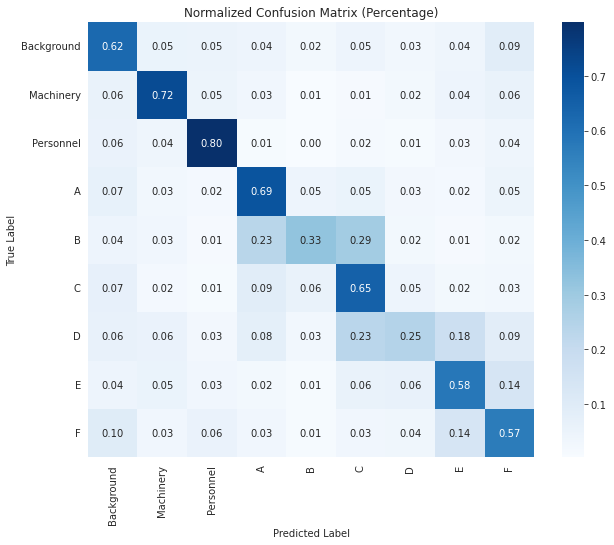

In [29]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'cm' is your confusion matrix computed using scikit-learn, e.g.:
# cm = confusion_matrix(all_gt, all_pred, labels=list(range(num_classes)))

# Normalize the confusion matrix by row (i.e. true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame for better labeling using your class_names dictionary
cm_normalized_df = pd.DataFrame(cm_normalized,
                                index=[class_names[i] for i in range(num_classes)],
                                columns=[class_names[i] for i in range(num_classes)])

# Plot the normalized confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized_df, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (Percentage)")

# Save the plot within the local Git repository
repo_dir = "/home/leeely/PycharmProjects/Turkey-Building-Data"
save_path = os.path.join(repo_dir, "Plots")
os.makedirs(save_path, exist_ok=True)
plot_path = os.path.join(save_path, "confusion_matrix_heatmap.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

New run overall accuracy: 0.56

In [30]:
def aggregate_mask(mask, method='mode'):
    """Aggregate the pixel-wise labels in a mask into a single score, using only damage-level classes (A–F)."""
    flat = mask.flatten()

    # Keep only valid building damage labels
    valid_labels = [3, 4, 5, 6, 7, 8]
    flat_valid = flat[np.isin(flat, valid_labels)]

    if len(flat_valid) == 0:
        return 0  # Or consider returning np.nan if you'd prefer to skip these

    if method == 'mode':
        return mode(flat_valid, keepdims=True).mode[0]
    elif method == 'weighted average':
        return np.mean(flat_valid)
    else:
        raise ValueError("Unknown aggregation method. Choose 'mode' or 'weighted average'.")


In [31]:
import numpy as np
from PIL import Image, ExifTags
import os
import pandas as pd
from scipy.stats import mode

# Paths
images_folder = "../resources/Building images with GPS"
masks_folder = "../resources/pred_masks_final"

def extract_gps_coordinates(image_path):
    """Extract latitude and longitude from an image's EXIF GPS data."""
    try:
        image = Image.open(image_path)
        exif_data = image._getexif()
        if not exif_data:
            return None

        exif = {ExifTags.TAGS.get(tag, tag): value for tag, value in exif_data.items()}
        if "GPSInfo" not in exif:
            return None

        gps_info = exif["GPSInfo"]
        latitude = gps_info.get(2)  # GPSLatitude
        latitude_ref = gps_info.get(1)  # 'N' or 'S'
        longitude = gps_info.get(4)  # GPSLongitude
        longitude_ref = gps_info.get(3)  # 'E' or 'W'

        if latitude and longitude and latitude_ref and longitude_ref:
            lat = latitude[0] + latitude[1] / 60.0 + latitude[2] / 3600.0
            lon = longitude[0] + longitude[1] / 60.0 + longitude[2] / 3600.0
            if latitude_ref == 'S':
                lat = -lat
            if longitude_ref == 'W':
                lon = -lon
            return lat, lon

        return None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Create a dictionary to store image GPS data
image_gps_data = {}

# Extract GPS data from images
for filename in os.listdir(images_folder):
    if filename.lower().endswith(('.jpg', '.jpeg')):  # Only check JPG images
        image_path = os.path.join(images_folder, filename)
        gps_coordinates = extract_gps_coordinates(image_path)
        if gps_coordinates:
            image_gps_data[filename] = gps_coordinates

# Create an array to store results
results = []

# Process masks and extract aggregation values
for mask_filename in os.listdir(masks_folder):
    if mask_filename.lower().endswith('.png'):  # Only process PNG masks
        mask_path = os.path.join(masks_folder, mask_filename)

        try:
            # Load mask as a NumPy array
            mask = np.array(Image.open(mask_path))

            # Compute aggregation values
            mode_value = aggregate_mask(mask, method='mode')
            weighted_avg = aggregate_mask(mask, method='weighted average')

            # Find corresponding image filename
            image_filename = mask_filename.replace('.png', '.jpg')  # Assuming masks and images match except for extension

            if image_filename in image_gps_data:
                latitude, longitude = image_gps_data[image_filename]
                results.append({
                    "Filename": image_filename,
                    "Latitude": latitude,
                    "Longitude": longitude,
                    "Mode": mode_value,
                    "Weighted Average": weighted_avg
                })
        except Exception as e:
            print(f"Error processing mask {mask_filename}: {e}")

# Convert to DataFrame
pred_df = pd.DataFrame(results)

# Display result
print(pred_df)

# Save as CSV (optional)
pred_df.to_csv("../resources/pred_agg_final.csv", index=False)


                                       Filename   Latitude  Longitude  Mode  \
0    {50930D18-9C78-436D-BD9D-6AE5EC2C74FC}.jpg  36.203508  36.158702     3   
1    {2A8304E5-B65C-4A49-A745-FD29854CEC7A}.jpg  37.751905  38.245082     8   
2    {61202A8E-4B72-4066-ABDB-7E19D342398A}.jpg  37.591485  36.867229     3   
3    {9CB58159-DB90-4641-BAAE-DA7D123CF1CA}.jpg  36.217220  36.156815     7   
4    {DDA542AC-C3F9-4589-8893-91160E066A98}.jpg  36.205974  36.160119     6   
..                                          ...        ...        ...   ...   
271  {ACED80DF-AC07-4AC7-A414-60E43822762C}.jpg  37.774595  38.265545     3   
272  {E316E926-E8EE-4EA4-B951-0736886C9B20}.jpg  37.559467  36.920900     7   
273  {09F10EDC-083A-4F26-BB6C-A9AE0CCD766B}.jpg  37.571785  36.934749     8   
274  {561F2B1A-FA0F-4657-B868-1510ADC53059}.jpg  36.213840  36.158352     5   
275  {2A00B94E-8B01-4342-8E9E-6E3DEFAD2B09}.jpg  37.756383  38.235597     8   

     Weighted Average  
0            5.732273  
1  

In [34]:
import numpy as np
from PIL import Image, ExifTags
import os
import pandas as pd
from scipy.stats import mode

# Paths
images_folder = "../resources/Building images with GPS"
gt_masks_folder = "../resources/Mask_final_relabelled"

# Create a dictionary to store image GPS data
image_gps_data = {}

# Extract GPS data from images
for filename in os.listdir(images_folder):
    if filename.lower().endswith(('.jpg', '.jpeg')):  # Only check JPG images
        image_path = os.path.join(images_folder, filename)
        gps_coordinates = extract_gps_coordinates(image_path)
        if gps_coordinates:
            image_gps_data[filename] = gps_coordinates

# Process Ground Truth Segmentation Masks
gt_results = []

for gt_mask_filename in os.listdir(gt_masks_folder):
    if gt_mask_filename.lower().endswith('.png'):  # Only process PNG masks
        gt_mask_path = os.path.join(gt_masks_folder, gt_mask_filename)

        try:
            # Load mask as a NumPy array
            gt_mask = np.array(Image.open(gt_mask_path))

            # Compute aggregation values
            mode_value = aggregate_mask(gt_mask, method='mode')
            weighted_avg = aggregate_mask(gt_mask, method='weighted average')

            # Find corresponding image filename in Original Images
            image_filename = gt_mask_filename.replace('.png', '.jpg')  # Convert PNG mask filename to JPG

            if image_filename in image_gps_data:
                latitude, longitude = image_gps_data[image_filename]
                gt_results.append({
                    "Filename": gt_mask_filename,
                    "Latitude": latitude,
                    "Longitude": longitude,
                    "Mode": mode_value,
                    "Weighted Average": weighted_avg
                })
        except Exception as e:
            print(f"Error processing mask {gt_mask_filename}: {e}")

# Convert to DataFrame
gt_df = pd.DataFrame(gt_results)

# Display result
print(gt_df)

# Save as CSV (optional)
gt_df.to_csv("../resources/gt_agg_final.csv", index=False)

                                       Filename   Latitude  Longitude  Mode  \
0    {50930D18-9C78-436D-BD9D-6AE5EC2C74FC}.png  36.203508  36.158702     8   
1    {2A8304E5-B65C-4A49-A745-FD29854CEC7A}.png  37.751905  38.245082     8   
2    {61202A8E-4B72-4066-ABDB-7E19D342398A}.png  37.591485  36.867229     3   
3    {9CB58159-DB90-4641-BAAE-DA7D123CF1CA}.png  36.217220  36.156815     8   
4    {DDA542AC-C3F9-4589-8893-91160E066A98}.png  36.205974  36.160119     7   
..                                          ...        ...        ...   ...   
271  {ACED80DF-AC07-4AC7-A414-60E43822762C}.png  37.774595  38.265545     8   
272  {E316E926-E8EE-4EA4-B951-0736886C9B20}.png  37.559467  36.920900     6   
273  {09F10EDC-083A-4F26-BB6C-A9AE0CCD766B}.png  37.571785  36.934749     8   
274  {561F2B1A-FA0F-4657-B868-1510ADC53059}.png  36.213840  36.158352     5   
275  {2A00B94E-8B01-4342-8E9E-6E3DEFAD2B09}.png  37.756383  38.235597     8   

     Weighted Average  
0            6.280405  
1  

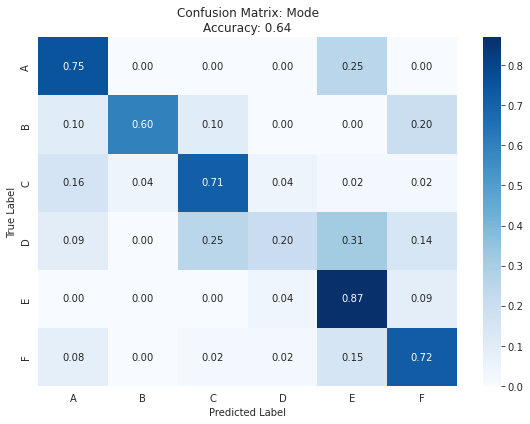

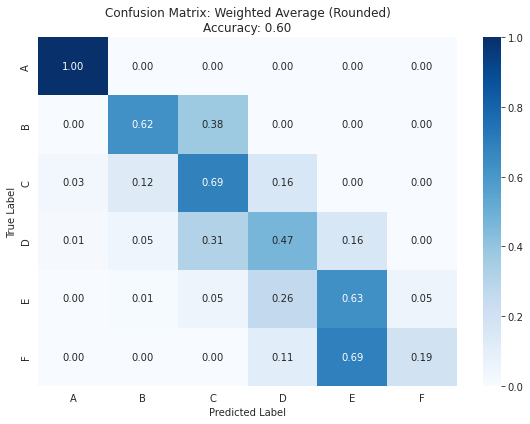

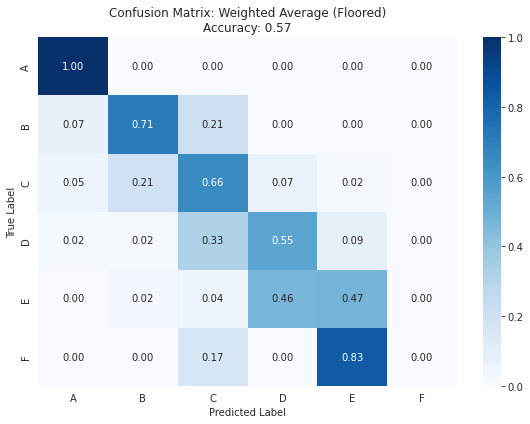

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

gt_path = '../resources/gt_agg_final.csv'
pred_path = '../resources/pred_agg_final.csv'

def evaluate_predictions(groundtruth, predicted):
    """
    Displays normalized confusion matrices with custom class labels and decimal values.
    Includes:
    - Mode
    - Weighted Average (Rounded)
    - Weighted Average (Floored)
    """
    valid_classes = [3, 4, 5, 6, 7, 8]
    class_labels = ["A", "B", "C", "D", "E", "F"]

    if isinstance(groundtruth, str):
        groundtruth = pd.read_csv(groundtruth)
    if isinstance(predicted, str):
        predicted = pd.read_csv(predicted)

    for col in ["Mode", "Weighted Average"]:
        if col not in groundtruth.columns or col not in predicted.columns:
            raise ValueError(f"Missing '{col}' in one of the dataframes.")

    def show_normalized_confusion(y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred, labels=valid_classes, normalize='true')
        accuracy = np.trace(cm) / len(valid_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.title(f"{title}\nAccuracy: {accuracy:.2f}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

    # 1. Mode
    show_normalized_confusion(
        groundtruth["Mode"],
        predicted["Mode"],
        "Confusion Matrix: Mode"
    )

    # 2. Weighted Average - Rounded
    wa_true_rounded = groundtruth["Weighted Average"].round().astype(int)
    wa_pred_rounded = predicted["Weighted Average"].round().astype(int)
    show_normalized_confusion(
        wa_true_rounded,
        wa_pred_rounded,
        "Confusion Matrix: Weighted Average (Rounded)"
    )

    # 3. Weighted Average - Floored
    wa_true_floored = np.floor(groundtruth["Weighted Average"]).astype(int)
    wa_pred_floored = np.floor(predicted["Weighted Average"]).astype(int)
    show_normalized_confusion(
        wa_true_floored,
        wa_pred_floored,
        "Confusion Matrix: Weighted Average (Floored)"
    )

# Call function
evaluate_predictions(gt_path, pred_path)


The following are the pixel labels from Alissa's tagging.  These means that I need to change the labels from the beginning.

0 - background

1 - C

2 - A

3 - B

4 - D

5 - E

6 - personnel

7 - machinery

8 - F